In [1]:
from shared import get_clean_data

#DATA_FILENAME = '/home/sami/py-graph/facebook_combined.txt.gz'
DATA_FILENAME = '/home/sami/py-graph/fb_simple.txt.gz'

print("Normalizing data (or loaded pre-computed)")
%time edges, num_edges, num_nodes = get_clean_data(DATA_FILENAME, shuffle=False, save_readable=True)
print('\nEDGES SHAPE: {}'.format(edges.shape))

Normalizing data (or loaded pre-computed)
Parsing from zip. Will write to file /home/sami/py-graph/fb_simple.txt-cleaned.npy
ORIGINAL DIST: 170.37209302325581 MIN: 0 MAX: 347
CPU times: user 4.43 ms, sys: 3.98 ms, total: 8.41 ms
Wall time: 8.29 ms

EDGES SHAPE: (430, 2)


In [2]:
%load_ext Cython
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [57]:
%%cython
import numpy as np
cimport cython

cdef int UNMAPPED = -1

def linear_deterministic_greedy(int[:,::] edges,
                                int num_nodes,
                                int num_partitions,
                                int[::] partition):
    """
    This algorithm favors a cluster if it has many neighbors of a node, but
    penalizes the cluster if it is close to capacity.
    
    edges: An [:,2] array of edges.
    num_nodes: The number of nodes in the graph.
    num_partitions: How many partitions we are breaking the graph into.
    partition: The partition from a previous run. Used for restreaming.

    Returns: A new partition.
    """
    # The output partition

    if partition is None:
        partition = np.repeat(np.int32(UNMAPPED), num_nodes)

    cdef int[::] partition_sizes = np.zeros(num_partitions, dtype=np.int32)
         
    cdef int[::] partition_votes = np.zeros(num_partitions, dtype=np.int32)
    
    # Fine to be a little off, to stay integers
    cdef int partition_capacity = num_nodes / num_partitions
    
    cdef int last_left = edges[0,0]
    cdef int i = 0
    cdef int left = 0
    cdef int right = 0
    cdef int arg = 0
    cdef int max_arg = 0
    cdef int max_val = 0
    cdef int val = 0
    cdef int len_edges = len(edges)
    
    import time
    
    print ("EDGES:{}".format(len_edges))
    
    for i in range(len_edges):
        left = edges[i,0]
        right = edges[i,1]
    
        if last_left != left:
            # We have found a new node so assign last_left to a partition
            #print("Found a new node")
            #print("\tleft: {}".format(left))
            #print("\tright: {}".format(right))
                
            max_arg = 0
            max_val = (partition_votes[0]) * (
                       partition_capacity - partition_sizes[0])

            for arg in range(1, num_partitions):
                val = (partition_votes[arg]) * (
                       partition_capacity - partition_sizes[arg])
                if val > max_val:
                    max_arg = arg
                    max_val = val

            if max_val == 0:
                max_arg = arg
                # No neighbors (or multiple maxed out) so "randomly" select
                # the smallest partition
                for arg in range(i % num_partitions, num_partitions):
                    if partition_sizes[arg] < partition_capacity:
                        max_arg = arg
                        max_val = 1
                        break
                if max_val == 0:
                    for arg in range(0, i % num_partitions):
                        if partition_sizes[arg] < partition_capacity:
                            max_arg = arg
                            break


            partition_sizes[max_arg] += 1
            partition[last_left] = max_arg
            partition_votes[:] = 0
            last_left = left
            
            #print("\tpartition_sizes for {}: {}".format(partition_sizes[max_arg], max_arg))
            #print("\tmax_arg: {}".format(max_arg))
            #print("\tmax_val: {}".format(max_val))

            #time.sleep(1)
            
        if partition[right] != UNMAPPED:
            partition_votes[partition[right]] += 1


    # Clean up the last assignment
    max_arg = 0
    max_val = 0
    for arg in range(0, num_partitions):
        if partition_sizes[arg] < partition_capacity:
            val = (partition_votes[arg]) * (
                    1 - partition_sizes[arg] / partition_capacity)
            if val > max_val:
                max_arg = arg
                max_val = val
    partition[left] = max_arg

    return np.asarray(partition)

In [4]:
def draw_figures(waste_values, edge_score_values, num_partitions):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    
    (waste_axes, score_axes) = axes
    waste_axes.plot(waste_values, 'r')
    waste_axes.set_xlabel('Round')
    waste_axes.set_ylabel('Number of wasted bins')
    waste_axes.set_ylim(bottom=0)
    waste_axes.set_title('Wasted Bins: {} partitions'.format(num_partitions))
    
    score_axes.plot(edge_score_values, 'r')
    score_axes.set_xlabel('Round')
    score_axes.set_ylabel('Ratio of edges crossing partitions')
    score_axes.set_ylim(bottom=0)
    score_axes.set_title('Score: {} partitions'.format(num_partitions))
    
    fig.tight_layout()

In [53]:
from shared import score


def run_restreaming_greedy(edges, num_nodes, num_partitions=10, num_iterations=10):
    print('\n{} PARTITIONS'.format(num_partitions))
    assignments = None
    print('ROUND\tWASTE\tSCORE\tCUT')
    waste_values = []
    edge_score_values = []
    flipped_edges = numpy.flipud(edges).copy()

    for i in range(num_iterations):
        assignments = linear_deterministic_greedy(edges, num_nodes, num_partitions, assignments)
        (waste, edge_score, edges_cut) = score(assignments, edges)
        waste_values.append(waste)
        edge_score_values.append(edge_score)
        print('{}\t{:0.3f}\t{:0.3f}\t{}'.format(i, waste, edge_score, edges_cut))
    
    with open("assignments.txt", "w") as f:
        j = 0
        for a in assignments:
            f.write("{} {}\n".format(j,a))
            j += 1

    draw_figures(waste_values, edge_score_values, num_partitions)
    
def run_restreaming_greedy_stepped(edges, node):
    # XXX: this can certainly be optimised using memoryviews
    
    # initialise left node to first item in edge list
    left = edges[0][0]
    stepped_edges = []
    count = 0
    node += 1

    for e in edges:
        if left != e[0]:
            left = e[0]

        if left == node:
            break
            
        stepped_edges.append(e)
        count += 1

    m = max([x[0] for x in stepped_edges])
    stepped_edges = [[x[0],x[1]] for x in stepped_edges if x[1] <= m]
    if not stepped_edges:
        return (np.zeros((1, 2), dtype=np.int32), 0)
    
    num_nodes = max([x[0] for x in stepped_edges] + [x[1] for x in stepped_edges]) + 1
    as_array = np.zeros((len(stepped_edges), 2), dtype=np.int32)
    for (i, (n_0, n_1)) in enumerate(stepped_edges):
        as_array[i,0] = n_0
        as_array[i,1] = n_1
    return (as_array, num_nodes)

In [64]:
# Use the greedy method to break into 4 partitions
#%time run_restreaming_greedy(edges, num_nodes, num_partitions=4, num_iterations=15)

print("EDGES: len({})".format(len(edges),type(edges)))

assignments = None
for node in range(1, 20):
    e, num_nodes = run_restreaming_greedy_stepped(edges, node)
    print(num)
    print(len(e))
    #print(e)
    # XXX: num_nodes is the wrong value here, it should be num_edges,
    # however we are dealing with an undirected graph so we can't simply len(e)
    assignments = linear_deterministic_greedy(e, num_nodes, 4, assignments)
    print("Node: {} -> assignment: {}".format(node, assignments[node]))
    
    #print("e: len({})".format(len(e),type(e)))


with open("assignments.txt", "w") as f:
    j = 0
    for a in assignments:
        f.write("{} {}\n".format(j,a))
        j += 1

print(assignments)


EDGES: len(430)
6
2
EDGES:2
Node: 1 -> assignment: 0
6
4
EDGES:4


IndexError: Out of bounds on buffer access (axis 0)


40 PARTITIONS
ROUND	WASTE	SCORE	CUT
0	0.367	0.680	119966
1	0.367	0.633	111624
2	0.367	0.590	104156
3	0.367	0.583	102876
4	0.367	0.599	105668
5	0.367	0.552	97490
6	0.367	0.554	97768
7	0.367	0.553	97612
8	0.367	0.540	95268
9	0.367	0.539	95030
10	0.367	0.541	95398
11	0.367	0.531	93636
12	0.367	0.536	94672
13	0.367	0.552	97484
14	0.367	0.529	93306
CPU times: user 183 ms, sys: 3.82 ms, total: 186 ms
Wall time: 185 ms


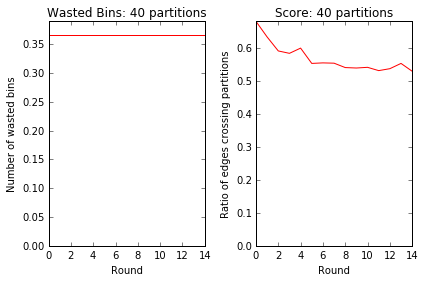

In [7]:
# Use the greedy method to break into 20 partitions
%time run_restreaming_greedy(edges, num_nodes, num_partitions=40, num_iterations=15)